In [1]:
import pandas as pd
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers import Embedding, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, Lambda
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K


import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
K.set_session(tf.Session(config=config))

MAX_NB_WORDS = 100000
MAX_PARAGRAPH_LENGTH = 200
MAX_QUESTION_LENGTH = 30

X_train = pd.read_csv('../train_task_b.csv')


import pymorphy2
morph = pymorphy2.MorphAnalyzer()

Using TensorFlow backend.


In [2]:
word_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, split=" ", char_level=False)
word_tokenizer.fit_on_texts(X_train.paragraph.tolist() + X_train.question.tolist())

train_sequences_1 = word_tokenizer.texts_to_sequences(X_train.paragraph.tolist())
train_sequences_2 = word_tokenizer.texts_to_sequences(X_train.question.tolist())
train_sequences_3 = word_tokenizer.texts_to_sequences(X_train.answer.tolist())

train_sequences_1 = pad_sequences(train_sequences_1, maxlen=MAX_PARAGRAPH_LENGTH)
train_sequences_2 = pad_sequences(train_sequences_2, maxlen=MAX_QUESTION_LENGTH)
#train_sequences_3 = pad_sequences(train_sequences_3, maxlen=MAX_QUESTION_LENGTH)
train_sequences_3 = np.array(train_sequences_3)


char_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, split=" ", char_level=True)
char_tokenizer.fit_on_texts(X_train.paragraph + X_train.question)


def find(arr, sub_arr):
    for i in range(len(arr) - len(sub_arr)):
        flag = 1
        for j in range(len(sub_arr)):
            if arr[i + j] != sub_arr[j]:
                flag = 0
        if flag == 1:
            return i, i + len(sub_arr)
        
        
start_end = np.zeros([len(train_sequences_1),2])
for i in range(len(train_sequences_1)):
    start_end[i] = find(train_sequences_1[i], train_sequences_3[i])
    
    
from gensim.models import KeyedVectors

#word2vec = KeyedVectors.load_word2vec_format('../ruwikiruscorpora_0_300_20.bin', binary=True)
#word2vec = KeyedVectors.load_word2vec_format('../news_0_300_2.bin', binary=True)
word2vec = KeyedVectors.load_word2vec_format('../ruscorpora_1_600_2.bin', binary=True)         

In [3]:
X_train['paragraph'] = X_train['paragraph'].apply(lambda x: x.lower().split())
X_train['question'] = X_train['question'].apply(lambda x: x.lower().split())
X_train['answer'] = X_train['answer'].apply(lambda x: x.lower().split())

train_sequences_1_ = X_train.paragraph.apply(lambda x: pad_sequences(char_tokenizer.texts_to_sequences(x), maxlen=20).tolist()[-200:])
train_sequences_2_ = X_train.question.apply(lambda x: pad_sequences(char_tokenizer.texts_to_sequences(x), maxlen=20).tolist()[-30:])
train_sequences_3_ = X_train.answer.apply(lambda x: pad_sequences(char_tokenizer.texts_to_sequences(x), maxlen=20).tolist()[-30:])

In [4]:
tmp = train_sequences_1_.apply(lambda x: np.vstack((np.zeros([201-len(x), 20]),np.array(x))))
arr = []
for i in np.array(tmp):
    arr += [i.tolist()]
train_sequences_1_ = np.array(arr)

tmp = train_sequences_2_.apply(lambda x: np.vstack((np.zeros([31-len(x), 20]),np.array(x))))
arr = []
for i in np.array(tmp):
    arr += [i.tolist()]
train_sequences_2_ = np.array(arr)

tmp = train_sequences_3_.apply(lambda x: np.vstack((np.zeros([31-len(x), 20]),np.array(x))))
arr = []
for i in np.array(tmp):
    arr += [i.tolist()]
train_sequences_3_ = np.array(arr)


train_sequences_1_ = train_sequences_1_[:,:200,:]
train_sequences_2_ = train_sequences_2_[:,:30,:]
train_sequences_3_ = train_sequences_3_[:,:30,:]

In [5]:
word_index = char_tokenizer.word_index

embedding_char1 = Embedding(len(word_index),
                            50,
                            input_length=20,
                            trainable=True)

In [6]:
def get_vect(p):
    vect = []
    for i in list(p.KNOWN_GRAMMEMES):
        if i in p:
            vect += [1]
        else:
            vect += [0]
    return np.array(vect)

from tqdm import tqdm
word_index = word_tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 720))
cnt = 0 
for word, i in tqdm(word_index.items()):
    p = morph.parse(word)[0]
    vect = get_vect(p.tag)
    word = p.normalized[0]
    for part_sp in p.tag.PARTS_OF_SPEECH:
        if word+'_'+part_sp in word2vec.vocab:
            embedding_matrix[i] = np.concatenate((word2vec.word_vec(word+'_'+part_sp), vect))
            #embedding_matrix[i] = word2vec.word_vec(word+'_'+part_sp)
            cnt += 1
            break

100%|██████████| 139609/139609 [00:39<00:00, 3548.72it/s]


In [7]:
embedding_layer1 = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=MAX_PARAGRAPH_LENGTH,
                            trainable=True)

embedding_layer2 = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=MAX_QUESTION_LENGTH,
                            trainable=True)

embedding_layer3 = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=1,
                            trainable=True)

In [8]:
in_answer = np.zeros([len(train_sequences_1),200])
idx = 0
for u, v in tqdm(zip(train_sequences_1,train_sequences_3)):
    tmp = []
    for i in u:
        tmp += [i in v]
    in_answer[idx] = tmp
    idx += 1

50364it [00:46, 1088.32it/s]


In [9]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=5)

folds = []
for itr, ite in group_kfold.split(X_train.paragraph_id, X_train.paragraph_id, X_train.paragraph_id):
    folds += [[itr, ite]]

# Эксперименты

In [10]:
from keras import backend as K
import numpy as np
from keras.layers import add
from keras.layers.core import Reshape
from keras.layers.wrappers import Bidirectional 
from keras.layers import multiply, average, Flatten
import keras.backend as K
import numpy as np



from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers import Concatenate

INPUT_DIM = 2
TIME_STEPS = 20
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False
 

def attention_3d_block230(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, 230))(a)
    a = Dense(230, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec230')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul230', mode='mul')
    return output_attention_mul

def attention_3d_block200(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, 200))(a)
    a = Dense(200, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec200')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul200', mode='mul')
    return output_attention_mul



In [11]:
LSTM_DIM = 200

import keras
def ker(x):
    x1 = x[0]
    x1 = Reshape((200, LSTM_DIM*2, 1))(x1)
    x1 = concatenate([x1]*30, axis=3) 
    
    x2 = x[1]
    x2 = Reshape((30, LSTM_DIM*2, 1))(x2)
    x2 = concatenate([x2]*200, axis=3) 
    x2 = Reshape((200, 30, LSTM_DIM*2))(x2)
    x1 = Reshape((200, 30, LSTM_DIM*2))(x1)
    m = multiply([x1, x2])
    matr = concatenate([x1, x2, m])

    #matr = TimeDistributed(Dense(1),input_shape=(200, 30))(matr)  

    matr = Dense(1)(matr)  
    matr = Reshape((200, 30))(matr)
    
    res1 = keras.backend.max(matr, axis=2) 
    res1 = Dense(200, activation='softmax')(res1)
    res1 = Reshape((1,200))(res1)
    res1 = K.batch_dot(res1, x[0])
    res1 = concatenate([res1]*200,axis=1)
    
    res2 = Dense(30, activation='softmax')(matr)
    res2 = K.batch_dot(res2, x[1])
    
    res = concatenate([res1, res2], axis=2)
    return res

In [12]:
def get_model():
    from keras.layers.merge import concatenate
    from keras.layers import multiply, average
    import keras

    LSTM_DIM = 200

    
    ch_lstm_p = LSTM(30, return_sequences=False)
    ch_input_p = Input(shape=(200,20,), dtype='int32')
    ch_emb_p = TimeDistributed(embedding_char1)(ch_input_p)
    ch_repr_p = TimeDistributed(ch_lstm_p)(ch_emb_p)


    ch_lstm_q = LSTM(30, return_sequences=False)
    ch_input_q = Input(shape=(30,20,), dtype='int32')
    ch_emb_q = TimeDistributed(embedding_char1)(ch_input_q)
    ch_repr_q = TimeDistributed(ch_lstm_q)(ch_emb_q)

    
    
    lstm_layer1_1 = Bidirectional(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
    lstm_layer1_2 = Bidirectional(LSTM(200, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
    lstm_layer1_3 = Bidirectional(LSTM(200, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))

    lstm_layer2_1 = Bidirectional(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
    #lstm_layer2_2 = LSTM(200, dropout=0.2, recurrent_dropout=0.2,return_sequences=False)

    
    in_answer_input = Input(shape=(MAX_PARAGRAPH_LENGTH,), dtype='float32')
    in_answer_ = Reshape((200,1))(in_answer_input)

    
    sequence_1_input = Input(shape=(MAX_PARAGRAPH_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer1(sequence_1_input)
    #embedded_sequences_1 = concatenate([embedded_sequences_1, in_answer_],axis=2)
    embedded_sequences_1 = concatenate([embedded_sequences_1, ch_repr_p,in_answer_],axis=2)

    p = lstm_layer1_1(embedded_sequences_1)

    #x1 = lstm_layer1_2(x1)
    #x1 = lstm_layer1_3(x1)
    #x1 = attention_3d_block(x1)


    sequence_2_input = Input(shape=(MAX_QUESTION_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer2(sequence_2_input)
    embedded_sequences_2 = concatenate([embedded_sequences_2, ch_repr_q],axis=2)

    q = lstm_layer2_1(embedded_sequences_2)
    #x2 = lstm_layer2_2(x2)

    att = Lambda(ker)([p, q])

    
    

    merged = concatenate([p,att, in_answer_],axis=2)
    merged = lstm_layer1_2(merged)
    merged = lstm_layer1_3(merged)

    merged = attention_3d_block200(merged)
    merged = Dropout(0.1)(merged)
    
    merged = Dense(240, activation='relu')(merged)
    #merged = Dense(1, activation='relu')(merged)

    #merged = Flatten()(merged1)
    #merged = Reshape((200,))(merged)
    #merged = Dropout(0.1)(merged)

    #preds = Dense(200, activation='softmax')(merged)

    
    #merged = Dense(240, activation='relu')(merged)
    merged = Dropout(0.2)(merged)
    merged = Dense(120, activation='relu')(merged)
    merged = Dropout(0.2)(merged)
    
    preds1 = Dense(1, activation='sigmoid')(merged)
    preds2 = Dense(1, activation='sigmoid')(merged)
    
    import keras
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    sgd = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)


    model = Model(inputs=[sequence_1_input,ch_input_p, sequence_2_input,ch_input_q, in_answer_input], \
            outputs=[preds1, preds2])
    model.compile(loss='binary_crossentropy',
            optimizer=adam,
            metrics=['acc'])
    return model

In [13]:
p

Parse(word='коксарайское', tag=OpencorporaTag('ADJF neut,sing,nomn'), normal_form='коксарайский', score=0.4995704467353952, methods_stack=((<DictionaryAnalyzer>, 'райское', 16, 14), (<UnknownPrefixAnalyzer>, 'кокса')))

In [64]:
q

<tf.Tensor 'embedding_11_7/Gather:0' shape=(?, 30, 300) dtype=float32>

In [62]:
att

<tf.Tensor 'lambda_5/concatenate_24/concat:0' shape=(?, 200, 400) dtype=float32>

In [13]:
def all_generator(batch_size, tr_p, tr_p_, tr_q, tr_q_, st_end, in_ans_):
    while(1):
        idx = np.array(range(tr_p.shape[0]))
        np.random.shuffle(idx)
        x_train1 = np.zeros([batch_size, MAX_PARAGRAPH_LENGTH])
        x_train1_ = np.zeros([batch_size, MAX_PARAGRAPH_LENGTH, 20])

        x_train2 = np.zeros([batch_size, 30])
        x_train2_ = np.zeros([batch_size, 30, 20])
        #x_train3 = np.zeros([batch_size, 30])
        x_train3 = np.zeros([batch_size,200])

        y_train1 = np.zeros([batch_size,200,1])
        y_train2 = np.zeros([batch_size,200,1])

        curr_batch_size = 0
        for i in range(batch_size):
            y1 = []
            y2 = []

            a = []
            for j in range(200):
                y1 += [j == st_end[idx[i]][0]]
                y2 += [j == st_end[idx[i]][1]]
                #y += [j >= st_end[idx[i]][0] and j < st_end[idx[i]][1]]
                a += [tr_p[idx[i]][j] in tr_q[idx[i]]]
            x_train1[i] = tr_p[idx[i]]
            x_train2[i] = tr_q[idx[i]]
            
            x_train1_[i] = tr_p_[idx[i]]
            x_train2_[i] = tr_q_[idx[i]]

            x_train3[i] = np.array(a)#.reshape(200,1)
            
            y_train1[i] = np.array(y1).reshape(200,1)
            y_train2[i] = np.array(y2).reshape(200,1)

        yield ([x_train1,x_train1_, x_train2,x_train2_, x_train3], [y_train1,y_train2] )

In [18]:
#model = get_model()
model.load_weights('BiDAF2_2.h5')

In [14]:
batch_size = 30

pred_train = np.zeros([len(train_sequences_1_), 200])


id_fold = 2
for itr, ite in folds[2:3]:


    model = get_model()
    model_checkpoint = ModelCheckpoint('BiDAF2_{}.h5'.format(id_fold), save_best_only=True, save_weights_only=True, monitor='val_loss')
    model.fit_generator(all_generator(batch_size, train_sequences_1[itr],train_sequences_1_[itr],
                                      train_sequences_2[itr],train_sequences_2_[itr],
                                      start_end[itr], in_answer[itr]),
                        samples_per_epoch=100,
                        validation_data=all_generator(batch_size,train_sequences_1[ite],
                                                      train_sequences_1_[ite],train_sequences_2[ite],
                                                      train_sequences_2_[ite],start_end[ite], in_answer[ite]),
                        nb_val_samples=100,
                        nb_epoch=200,
                        verbose=1,
                        callbacks=[model_checkpoint])
    #model.load_weights('start_{}.h5'.format(id_fold))
    '''
    batch = len(val_sequences_1)
    x_train1 = np.zeros([batch,MAX_PARAGRAPH_LENGTH])
    x_train2 = np.zeros([batch,30])
    st_end = np.zeros([batch,2])

    for i in range(batch):
        x_train1[i] = val_sequences_1[i]
        x_train2[i] = val_sequences_2[i]
        st_end[i] = start_end_val[i]

    pred = model.predict([x_train1,x_train2])  
    pred_train[ite] = pred.reshape(10072,200)
    
    del model
    import gc
    gc.collect()
    '''

/home/afattahov/.local/lib/python3.5/site-packages/ipykernel_launcher.py:48: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/afattahov/tf3/lib/python3.5/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/afattahov/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
/home/afattahov/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_

Epoch 1/200
100/100 [==============================] - 236s - loss: 0.2947 - dense_10_loss: 0.1483 - dense_11_loss: 0.1464 - dense_10_acc: 0.9888 - dense_11_acc: 0.9890 - val_loss: 0.0578 - val_dense_10_loss: 0.0289 - val_dense_11_loss: 0.0289 - val_dense_10_acc: 0.9953 - val_dense_11_acc: 0.9953
Epoch 2/200
100/100 [==============================] - 228s - loss: 0.0586 - dense_10_loss: 0.0294 - dense_11_loss: 0.0292 - dense_10_acc: 0.9953 - dense_11_acc: 0.9953 - val_loss: 0.0580 - val_dense_10_loss: 0.0291 - val_dense_11_loss: 0.0289 - val_dense_10_acc: 0.9952 - val_dense_11_acc: 0.9952
Epoch 3/200
100/100 [==============================] - 229s - loss: 0.0591 - dense_10_loss: 0.0296 - dense_11_loss: 0.0295 - dense_10_acc: 0.9952 - dense_11_acc: 0.9952 - val_loss: 0.0580 - val_dense_10_loss: 0.0291 - val_dense_11_loss: 0.0289 - val_dense_10_acc: 0.9953 - val_dense_11_acc: 0.9953
Epoch 4/200
100/100 [==============================] - 233s - loss: 0.0594 - dense_10_loss: 0.0297 - dense

100/100 [==============================] - 227s - loss: 0.0583 - dense_10_loss: 0.0292 - dense_11_loss: 0.0291 - dense_10_acc: 0.9952 - dense_11_acc: 0.9952 - val_loss: 0.0575 - val_dense_10_loss: 0.0287 - val_dense_11_loss: 0.0288 - val_dense_10_acc: 0.9953 - val_dense_11_acc: 0.9953
Epoch 29/200
100/100 [==============================] - 227s - loss: 0.0578 - dense_10_loss: 0.0289 - dense_11_loss: 0.0289 - dense_10_acc: 0.9953 - dense_11_acc: 0.9953 - val_loss: 0.0577 - val_dense_10_loss: 0.0289 - val_dense_11_loss: 0.0288 - val_dense_10_acc: 0.9952 - val_dense_11_acc: 0.9952
Epoch 30/200
100/100 [==============================] - 227s - loss: 0.0580 - dense_10_loss: 0.0291 - dense_11_loss: 0.0290 - dense_10_acc: 0.9952 - dense_11_acc: 0.9952 - val_loss: 0.0570 - val_dense_10_loss: 0.0285 - val_dense_11_loss: 0.0284 - val_dense_10_acc: 0.9953 - val_dense_11_acc: 0.9953
Epoch 31/200
100/100 [==============================] - 228s - loss: 0.0578 - dense_10_loss: 0.0290 - dense_11_loss:

100/100 [==============================] - 227s - loss: 0.0574 - dense_10_loss: 0.0287 - dense_11_loss: 0.0286 - dense_10_acc: 0.9953 - dense_11_acc: 0.9953 - val_loss: 0.0570 - val_dense_10_loss: 0.0285 - val_dense_11_loss: 0.0285 - val_dense_10_acc: 0.9953 - val_dense_11_acc: 0.9953
Epoch 56/200
100/100 [==============================] - 225s - loss: 0.0580 - dense_10_loss: 0.0290 - dense_11_loss: 0.0290 - dense_10_acc: 0.9952 - dense_11_acc: 0.9952 - val_loss: 0.0575 - val_dense_10_loss: 0.0288 - val_dense_11_loss: 0.0287 - val_dense_10_acc: 0.9952 - val_dense_11_acc: 0.9952
Epoch 57/200
100/100 [==============================] - 225s - loss: 0.0577 - dense_10_loss: 0.0289 - dense_11_loss: 0.0287 - dense_10_acc: 0.9953 - dense_11_acc: 0.9953 - val_loss: 0.0572 - val_dense_10_loss: 0.0286 - val_dense_11_loss: 0.0286 - val_dense_10_acc: 0.9953 - val_dense_11_acc: 0.9953
Epoch 58/200
100/100 [==============================] - 226s - loss: 0.0575 - dense_10_loss: 0.0287 - dense_11_loss:

100/100 [==============================] - 226s - loss: 0.0576 - dense_10_loss: 0.0288 - dense_11_loss: 0.0287 - dense_10_acc: 0.9952 - dense_11_acc: 0.9952 - val_loss: 0.0562 - val_dense_10_loss: 0.0281 - val_dense_11_loss: 0.0281 - val_dense_10_acc: 0.9953 - val_dense_11_acc: 0.9953
Epoch 83/200
100/100 [==============================] - 225s - loss: 0.0576 - dense_10_loss: 0.0288 - dense_11_loss: 0.0287 - dense_10_acc: 0.9952 - dense_11_acc: 0.9952 - val_loss: 0.0564 - val_dense_10_loss: 0.0282 - val_dense_11_loss: 0.0282 - val_dense_10_acc: 0.9953 - val_dense_11_acc: 0.9953
Epoch 84/200
100/100 [==============================] - 226s - loss: 0.0573 - dense_10_loss: 0.0287 - dense_11_loss: 0.0286 - dense_10_acc: 0.9952 - dense_11_acc: 0.9952 - val_loss: 0.0569 - val_dense_10_loss: 0.0285 - val_dense_11_loss: 0.0284 - val_dense_10_acc: 0.9953 - val_dense_11_acc: 0.9953
Epoch 85/200
100/100 [==============================] - 224s - loss: 0.0581 - dense_10_loss: 0.0291 - dense_11_loss:

100/100 [==============================] - 223s - loss: 0.0577 - dense_10_loss: 0.0289 - dense_11_loss: 0.0288 - dense_10_acc: 0.9952 - dense_11_acc: 0.9952 - val_loss: 0.0569 - val_dense_10_loss: 0.0284 - val_dense_11_loss: 0.0284 - val_dense_10_acc: 0.9953 - val_dense_11_acc: 0.9953
Epoch 110/200
100/100 [==============================] - 223s - loss: 0.0575 - dense_10_loss: 0.0287 - dense_11_loss: 0.0287 - dense_10_acc: 0.9952 - dense_11_acc: 0.9952 - val_loss: 0.0571 - val_dense_10_loss: 0.0286 - val_dense_11_loss: 0.0285 - val_dense_10_acc: 0.9953 - val_dense_11_acc: 0.9953
Epoch 111/200
100/100 [==============================] - 225s - loss: 0.0571 - dense_10_loss: 0.0286 - dense_11_loss: 0.0285 - dense_10_acc: 0.9953 - dense_11_acc: 0.9953 - val_loss: 0.0572 - val_dense_10_loss: 0.0286 - val_dense_11_loss: 0.0286 - val_dense_10_acc: 0.9952 - val_dense_11_acc: 0.9952
Epoch 112/200
100/100 [==============================] - 223s - loss: 0.0572 - dense_10_loss: 0.0287 - dense_11_lo

KeyboardInterrupt: 

In [ ]:
    model.fit_generator(all_generator(batch_size, train_sequences_1[itr],train_sequences_1_[itr],
                                      train_sequences_2[itr],train_sequences_2_[itr],
                                      start_end[itr], in_answer[itr]),
                        samples_per_epoch=100,
                        validation_data=all_generator(batch_size,train_sequences_1[ite],
                                                      train_sequences_1_[ite],train_sequences_2[ite],
                                                      train_sequences_2_[ite],start_end[ite], in_answer[ite]),
                        nb_val_samples=100,
                        nb_epoch=100,
                        verbose=1,
                        callbacks=[model_checkpoint])

In [15]:
id_fold = 2
for itr, ite in folds[2:3]:
    1

In [23]:
pred_train[ite] = pred.reshape(10073,200)


In [24]:
pred_train

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.34185357e-02,   6.66043721e-04,   5.06718170e-05, ...,
          7.95502492e-05,   1.69122490e-04,   2.93145247e-04],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.40094012e-02,   7.26349768e-04,   5.62102068e-05, ...,
          3.97460499e-05,   1.04612591e-04,   1.08490477e-03]])

In [25]:
pd.DataFrame(pred_train).to_csv('start_2.csv')


In [38]:
pred = model.predict([x_train1,x_train2])    

In [45]:
pred.shape

(20, 200, 2)

In [16]:
#batch = len(val_sequences_1)
batch = 100

val_sequences_1 = train_sequences_1[ite]
val_sequences_2 = train_sequences_2[ite]
val_sequences_1_ = train_sequences_1_[ite]
val_sequences_2_ = train_sequences_2_[ite]
start_end_val = start_end[ite]
in_answer_val = in_answer[ite]

x_train1 = np.zeros([batch,MAX_PARAGRAPH_LENGTH])
x_train2 = np.zeros([batch,30])
x_train3 = np.zeros([batch,200])

x_train1_ = np.zeros([batch,MAX_PARAGRAPH_LENGTH, 20])
x_train2_ = np.zeros([batch,30, 20])

st_end = np.zeros([batch,2])


for i in range(batch):
    x_train1[i] = val_sequences_1[i]
    x_train2[i] = val_sequences_2[i]
    x_train3[i] = in_answer_val[i]
        
    x_train1_[i] = val_sequences_1_[i]
    x_train2_[i] = val_sequences_2_[i]
    
    st_end[i] = start_end_val[i]

    
    
pred1,pred2 = model.predict([x_train1, x_train1_,x_train2,x_train2_,in_answer_val])    
    
real_arr = []
for i in range(batch):
    real = []
    for j in range(200):
        real += [float(j >= st_end[i][0] and j < st_end[i][1]) / 5.0]
        #real += [float(j == st_end[i][1]-1) / 5.0]

    tmp = real
    real_arr += [tmp]

In [18]:
#batch = len(val_sequences_1)
batch = 100

val_sequences_1 = train_sequences_1[itr]
val_sequences_2 = train_sequences_2[itr]
val_sequences_1_ = train_sequences_1_[itr]
val_sequences_2_ = train_sequences_2_[itr]
start_end_val = start_end[itr]
in_answer_val = in_answer[itr]

x_train1 = np.zeros([batch,MAX_PARAGRAPH_LENGTH])
x_train2 = np.zeros([batch,30])
x_train3 = np.zeros([batch,200])

x_train1_ = np.zeros([batch,MAX_PARAGRAPH_LENGTH, 20])
x_train2_ = np.zeros([batch,30, 20])

st_end = np.zeros([batch,2])


for i in range(batch):
    x_train1[i] = val_sequences_1[i]
    x_train2[i] = val_sequences_2[i]
    x_train3[i] = in_answer_val[i]
        
    x_train1_[i] = val_sequences_1_[i]
    x_train2_[i] = val_sequences_2_[i]
    
    st_end[i] = start_end_val[i]

    
    
pred = model.predict([x_train1, x_train1_,x_train2,x_train2_,in_answer_val])    
    
real_arr = []
for i in range(batch):
    real = []
    for j in range(200):
        real += [float(j >= st_end[i][0] and j < st_end[i][1]) / 5.0]
        #real += [float(j == st_end[i][1]-1) / 5.0]

    tmp = real
    real_arr += [tmp]

Populating the interactive namespace from numpy and matplotlib


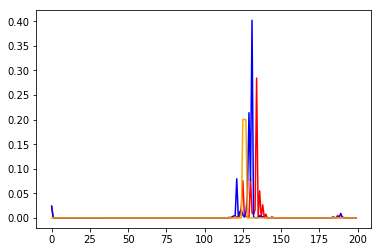

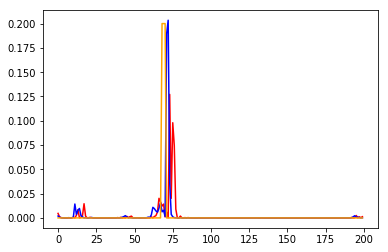

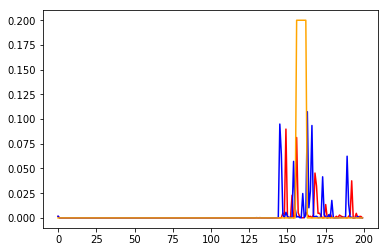

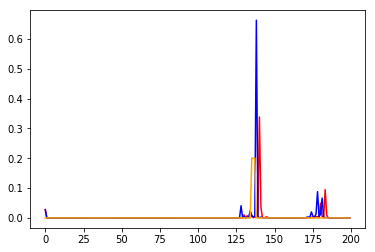

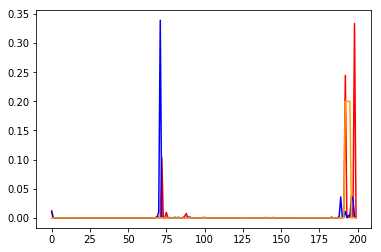

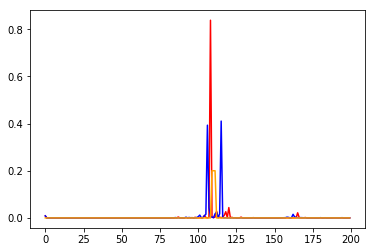

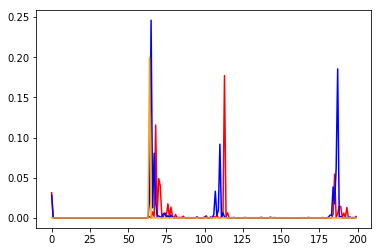

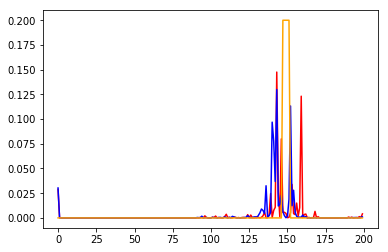

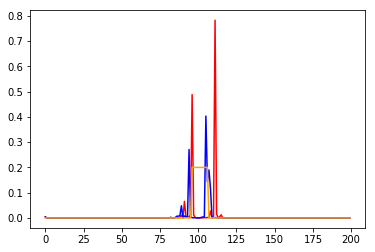

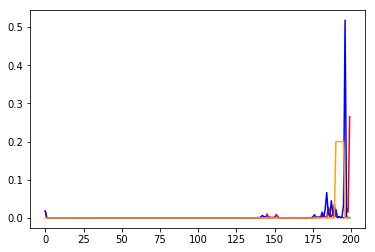

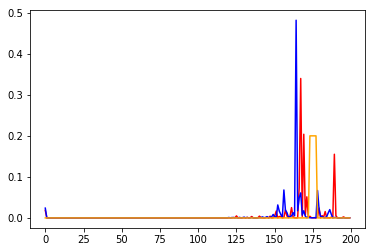

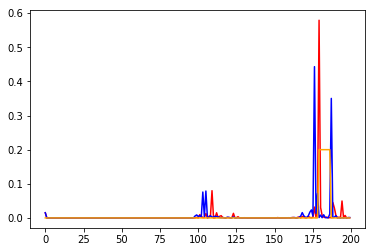

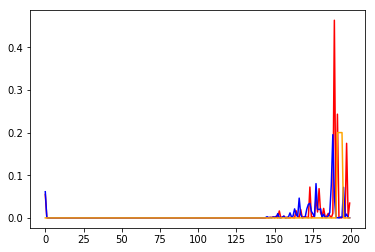

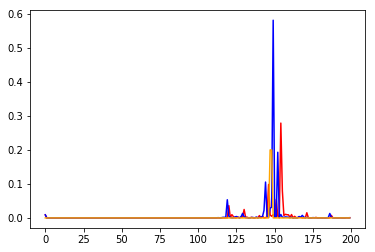

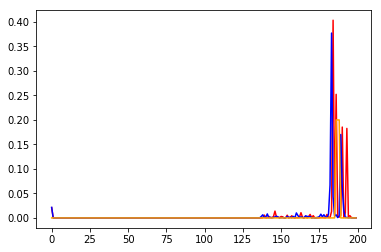

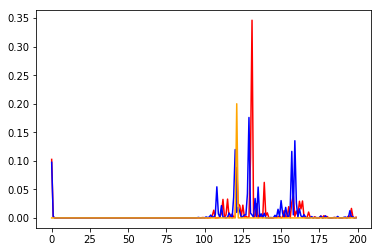

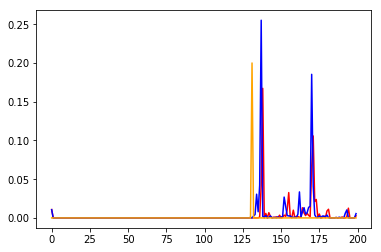

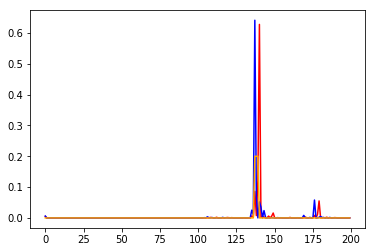

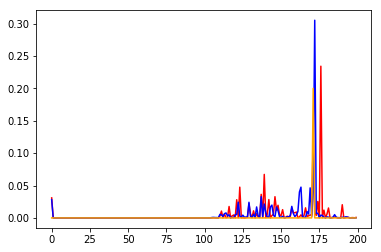

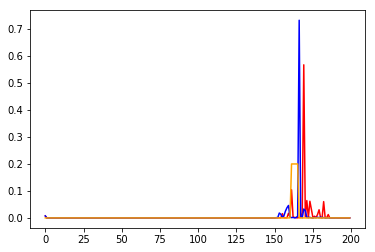

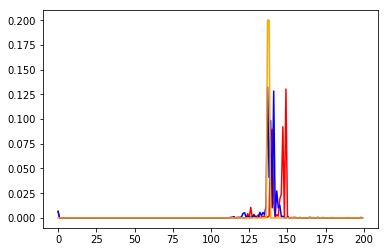

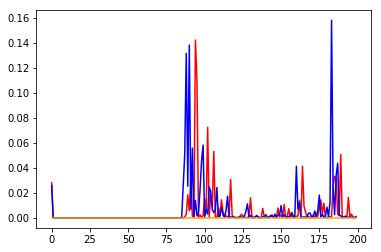

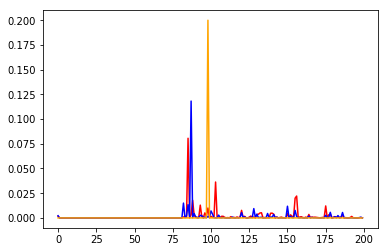

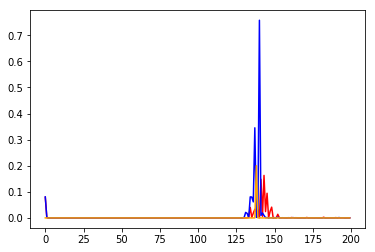

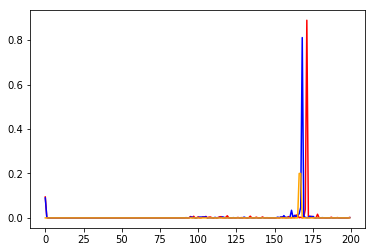

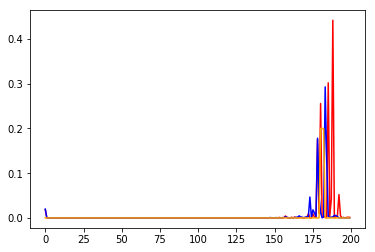

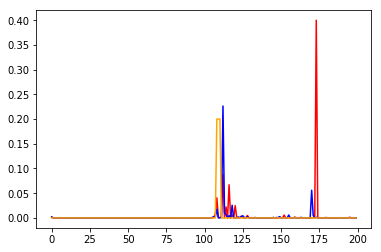

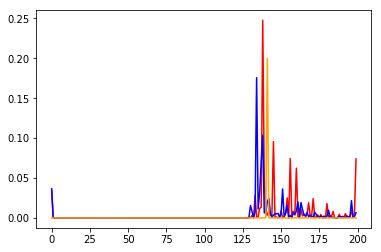

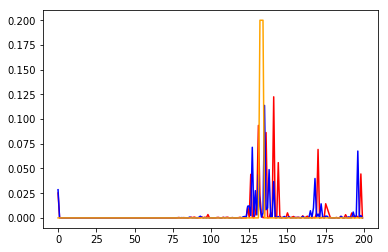

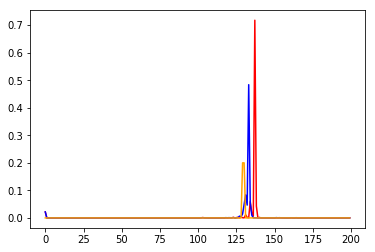

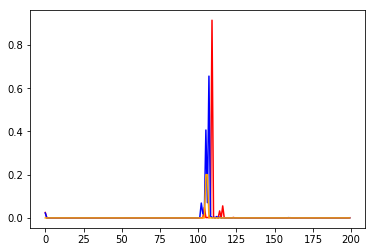

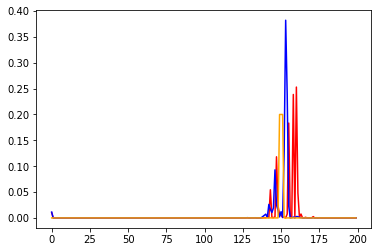

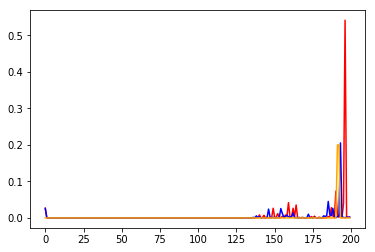

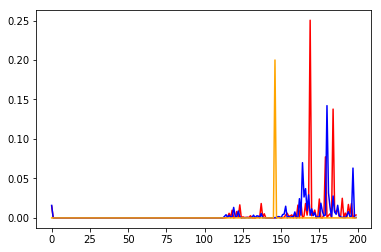

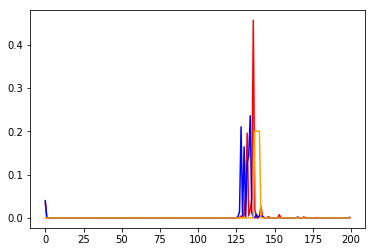

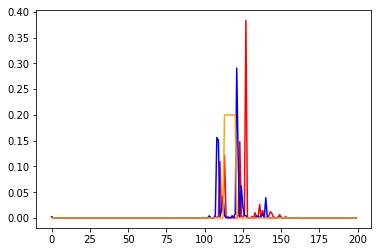

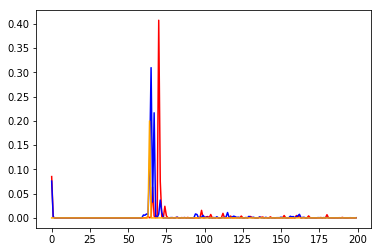

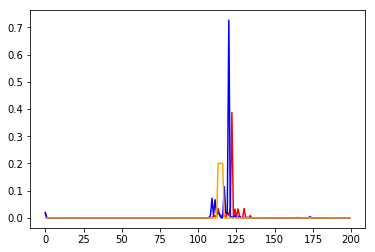

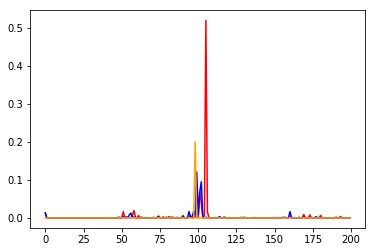

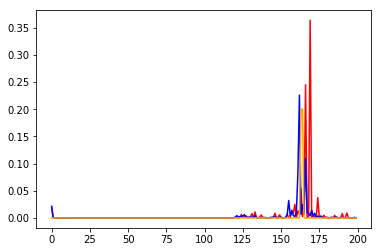

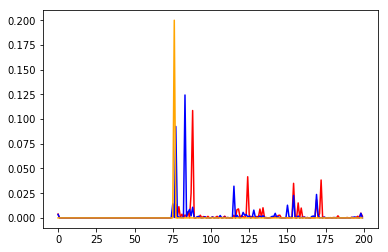

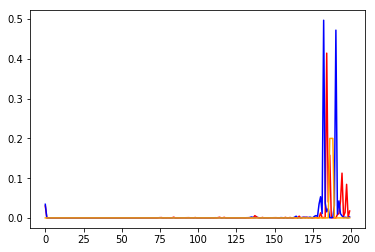

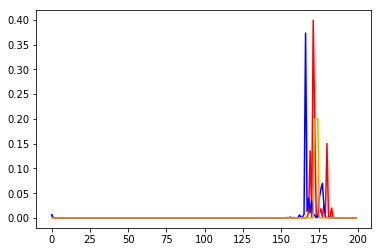

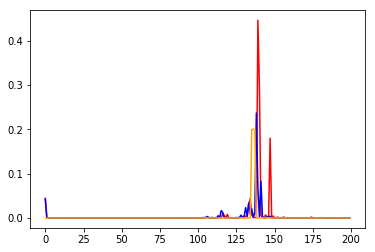

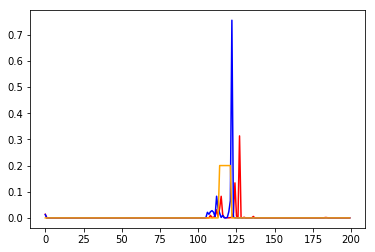

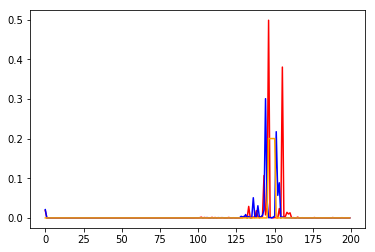

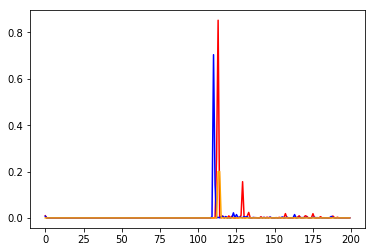

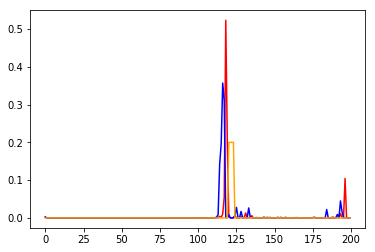

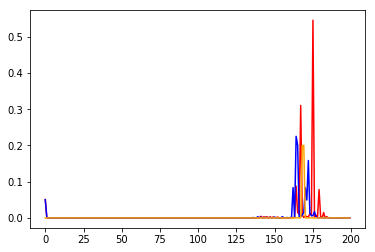

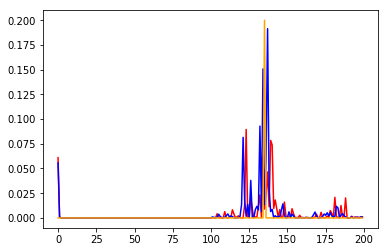

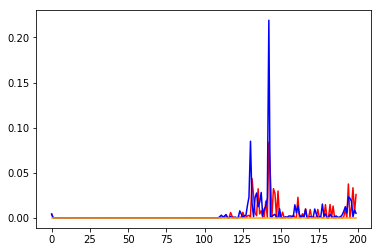

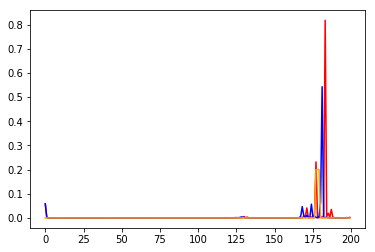

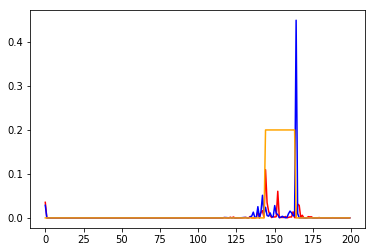

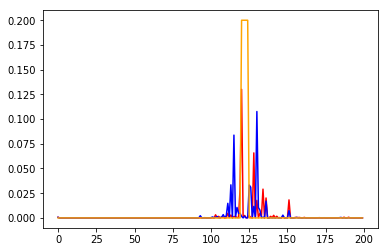

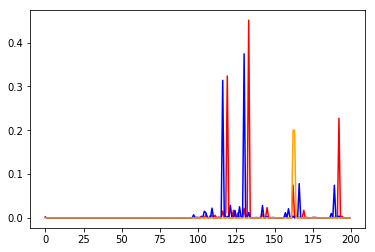

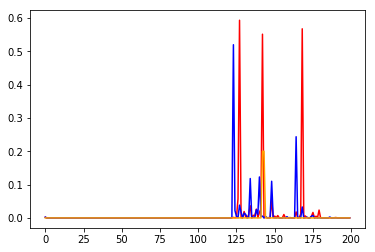

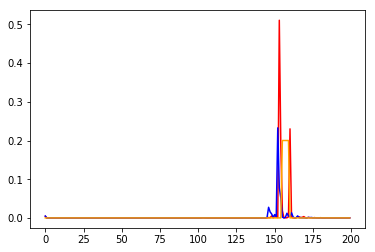

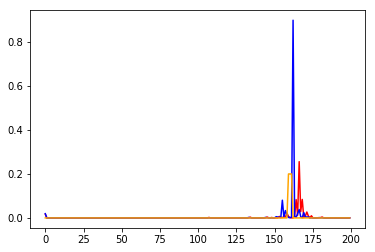

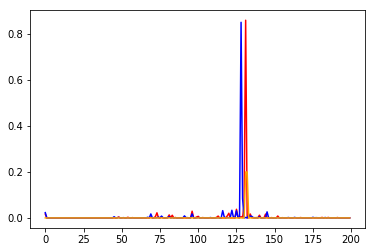

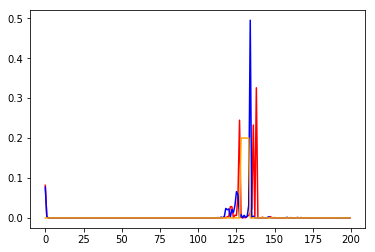

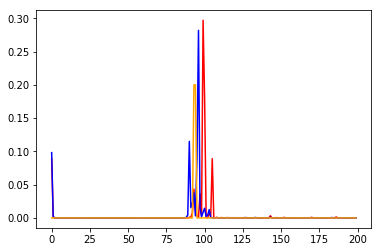

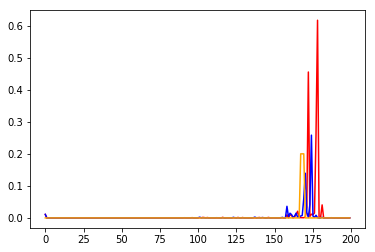

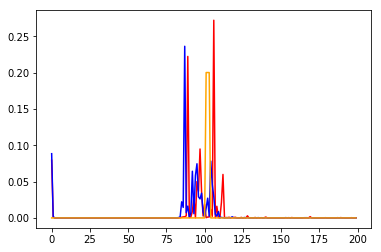

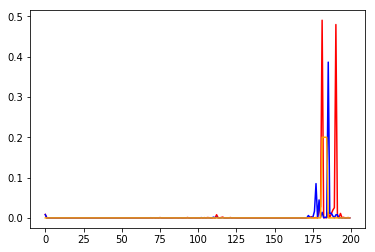

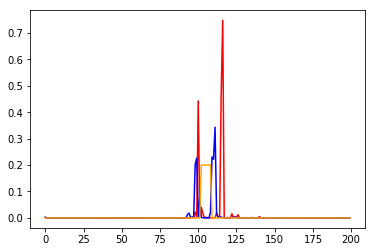

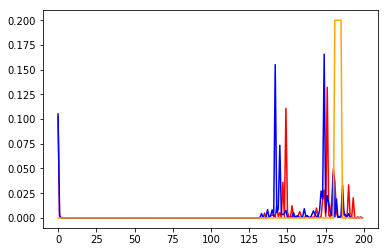

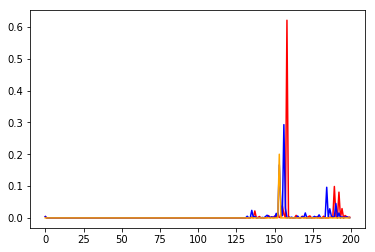

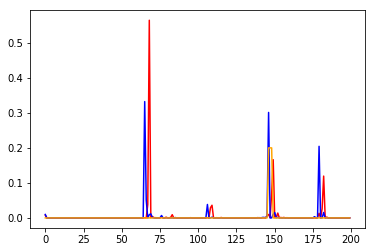

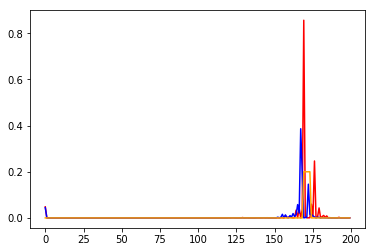

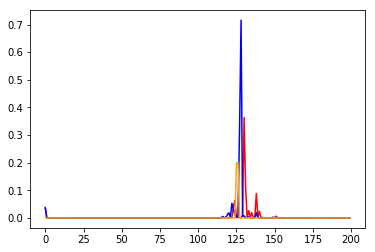

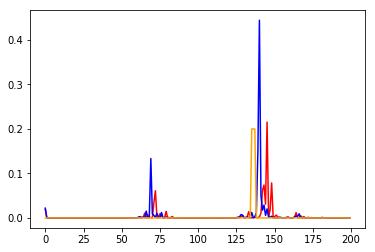

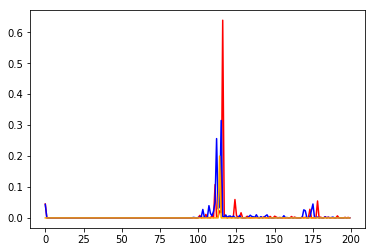

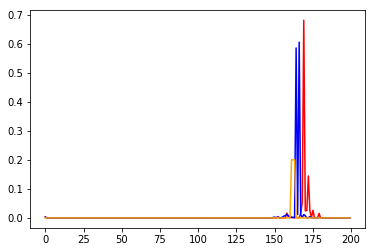

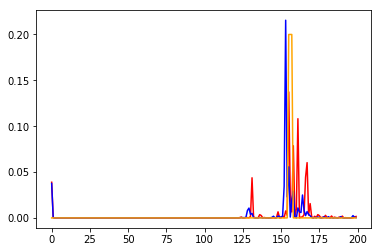

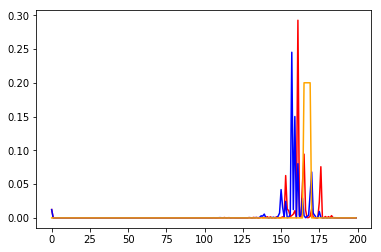

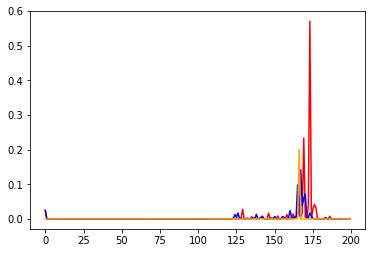

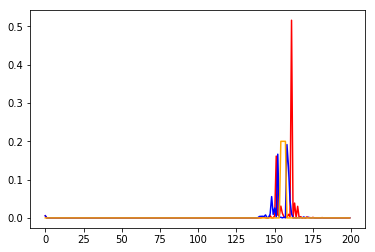

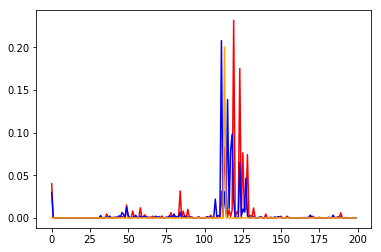

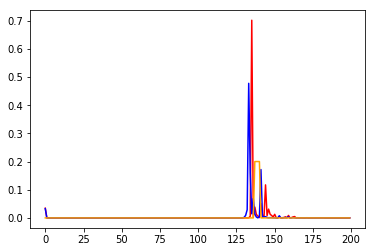

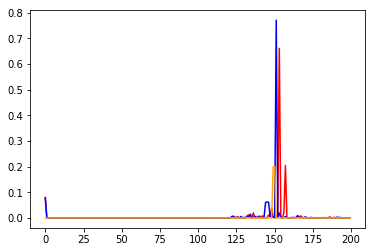

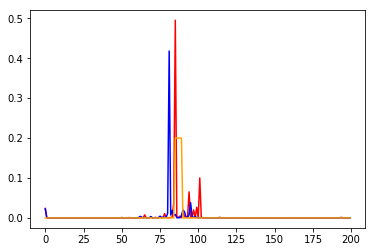

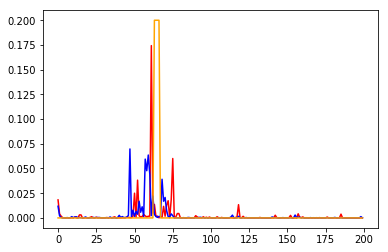

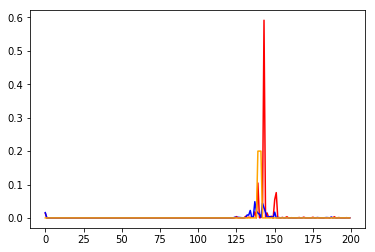

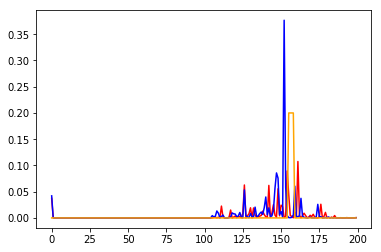

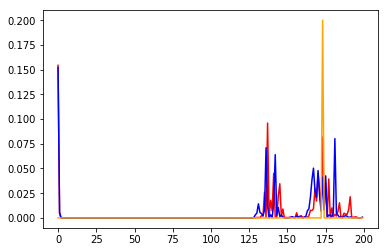

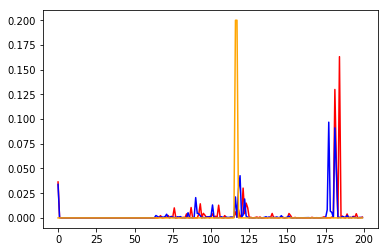

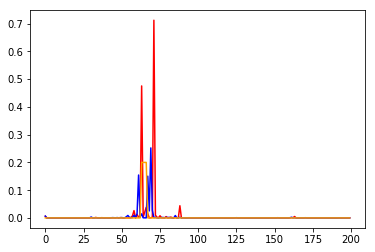

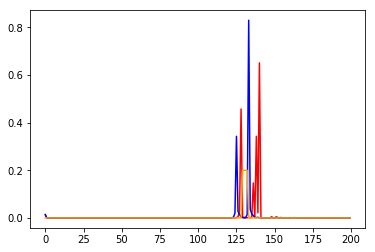

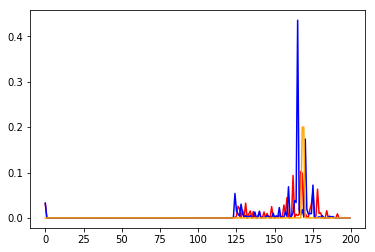

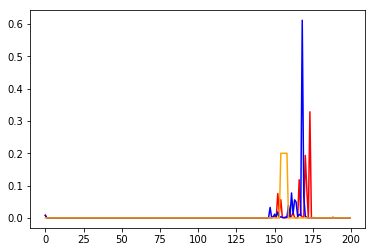

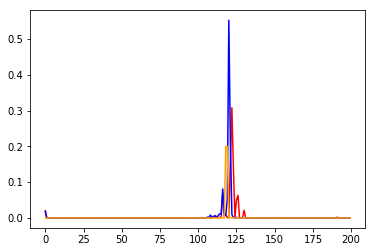

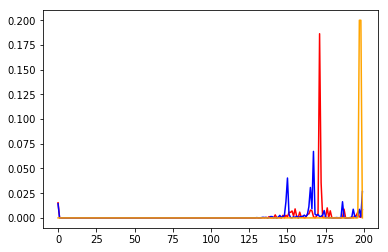

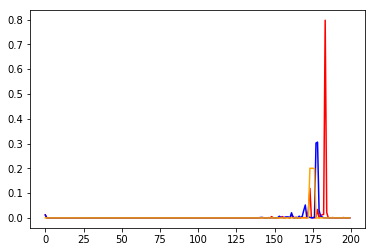

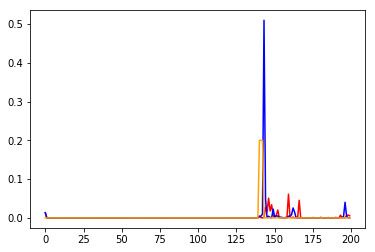

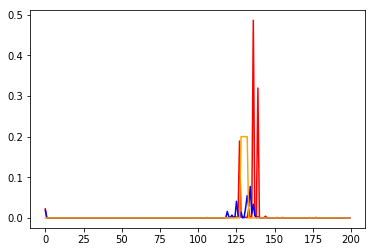

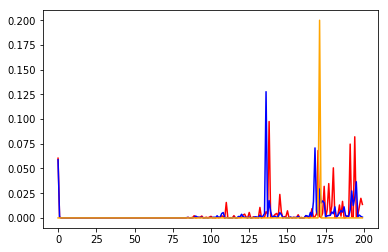

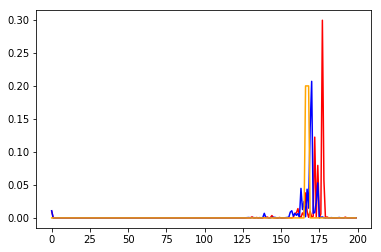

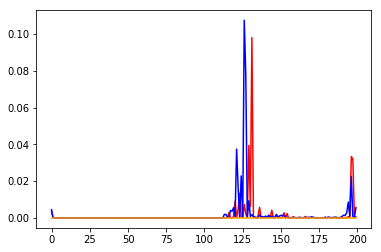

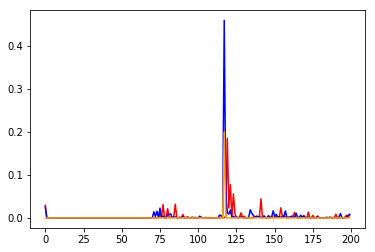

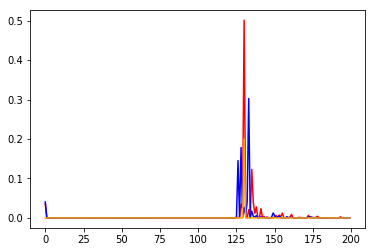

In [21]:
%matplotlib inline
%pylab inline
for i in range(batch):
    plt.plot(range(200), pred2[i].reshape(200),color='r')
    plt.plot(range(200), pred1[i].reshape(200),color='b')
    plt.plot(range(200), real_arr[i],color='orange')

    plt.show()

In [178]:
mask = pred > 0.09

predict = []
for i in range(len(val_sequences_1)):
    predict += [val_sequences_1[i][mask[i]]]

In [179]:
predict[0]

array([ 3182,     5,  3324, 15426,     2, 25770,  3836,  3665, 33643,
       38453,  1475,   962,   463,     3, 38478,  5317,  1336,  8667,
           2, 13692], dtype=int32)

In [180]:
def f1_score(prediction, ground_truth):
    if len(prediction) == 0:
        return 0
    if len(ground_truth) == 0:
        return 0
    precision = 1.0 * len(list(set(prediction) & set(ground_truth))) / len(prediction)
    recall = 1.0 * len(list(set(prediction) & set(ground_truth))) / len(ground_truth)
    if precision + recall != 0:
        f1 = (2 * precision * recall) / (precision + recall)
    else:
        f1 = 0
    return f1

In [136]:
f1_score(tmp, tmp1)

0.46153846153846156

In [181]:
f1_score(predict[0], val_sequences_3[0])

0.35714285714285715

In [182]:
f1 = []
for i in range(len(predict)):
    f1 += [f1_score(predict[i], val_sequences_3[i])]

In [183]:
np.array(f1).mean()

0.094258449787767276